In [1]:
!pip install -q ultralytics supervision transformers torch torchvision opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 4.5 MB/s eta 0:00:00


In [6]:
from huggingface_hub import login
login()


In [10]:

from huggingface_hub import hf_hub_download
from ultralytics import YOLO

sig_model_path = hf_hub_download(
    repo_id="tech4humans/yolov8s-signature-detector",
    filename="yolov8s.pt"
)

model_sig = YOLO(sig_model_path)
model_sig.to("cpu")

print("✅ Signature YOLO loaded")

yolov8s.pt:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

✅ Signature YOLO loaded


In [11]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained(
    "Ooredoo-Group/ooredoo-stamp-detection"
)

model_stamp = AutoModelForObjectDetection.from_pretrained(
    "Ooredoo-Group/ooredoo-stamp-detection"
).eval()

print("✅ Stamp model loaded")

preprocessor_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

✅ Stamp model loaded


In [19]:
# google colab upload image to /content, and store the path ref in a variable
# img_handler
from google.colab import files
import cv2

uploaded = files.upload()
image_path = next(iter(uploaded))

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print("📄 Image loaded:", image_path)

Saving 90019805709_1_v1_pg1.png to 90019805709_1_v1_pg1.png
📄 Image loaded: 90019805709_1_v1_pg1.png


In [13]:
def run_stamp_signature_detection(image_path):
    import cv2
    import torch
    import numpy as np
    from PIL import Image
    import supervision as sv

    # ----------------------------
    # Load image
    # ----------------------------
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # ============================================================
    # SIGNATURE DETECTION (YOLO)
    # ============================================================
    sig_results = model_sig.predict(
        source=image_path,
        conf=0.25,
        device="cpu",
        verbose=False
    )[0]

    raw_signature_output = sig_results

    signature_detections = []
    if sig_results.boxes is not None:
        for box in sig_results.boxes:
            signature_detections.append({
                "class": "signature",
                "bbox_xyxy": box.xyxy[0].tolist(),
                "confidence": float(box.conf[0])
            })

    # ============================================================
    # STAMP DETECTION (TRANSFORMER)
    # ============================================================
    inputs = processor(images=image_pil, return_tensors="pt")

    with torch.no_grad():
        stamp_outputs = model_stamp(**inputs)

    raw_stamp_output = stamp_outputs

    target_sizes = torch.tensor([image_pil.size[::-1]])

    processed = processor.post_process_object_detection(
        stamp_outputs,
        target_sizes=target_sizes,
        threshold=0.30
    )[0]

    stamp_detections = []
    for score, box in zip(processed["scores"], processed["boxes"]):
        stamp_detections.append({
            "class": "stamp",
            "bbox_xyxy": box.tolist(),
            "confidence": float(score)
        })

    # ============================================================
    # MERGED FORMATTED OUTPUT
    # ============================================================
    formatted_output = {
        "image": image_path,
        "detections": {
            "signature": signature_detections,
            "stamp": stamp_detections
        }
    }

    # ============================================================
    # VISUAL ANNOTATION
    # ============================================================
    detections = []

    for d in signature_detections:
        detections.append([*d["bbox_xyxy"], d["confidence"], 0])

    for d in stamp_detections:
        detections.append([*d["bbox_xyxy"], d["confidence"], 1])

    annotated_image = image_bgr.copy()

    if detections:
        det = sv.Detections(
            xyxy=np.array([d[:4] for d in detections]),
            confidence=np.array([d[4] for d in detections]),
            class_id=np.array([d[5] for d in detections])
        )

        labels = [
            f"{'signature' if c == 0 else 'stamp'} {conf:.2f}"
            for c, conf in zip(det.class_id, det.confidence)
        ]

        annotated_image = sv.BoxAnnotator(thickness=2).annotate(
            annotated_image, det
        )
        annotated_image = sv.LabelAnnotator().annotate(
            annotated_image, det, labels
        )

    # ============================================================
    # RETURN EVERYTHING
    # ============================================================
    return {
        "raw": {
            "signature": raw_signature_output,
            "stamp": raw_stamp_output
        },
        "formatted": formatted_output,
        "annotated_image": annotated_image
    }


In [20]:
result = run_stamp_signature_detection(image_path)


In [15]:
print(result)

{'raw': {'signature': ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'signature'}
obb: None
orig_img: array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[248, 241, 248],
        [248, 241, 248],
        [248, 241, 248],
        ...,
        [255, 255, 255],
        [218, 218, 218],
        [ 87,  87,  87]],

       [[248, 241, 248],
        [248, 241, 248],
        [248, 241, 248],
        ...,
        [254, 254, 254],
        [218,

In [21]:
# print("signature:", result["raw"]["signature"])
# print("stamp: ", result["raw"]["stamp"])
print("result: ", result["formatted"])

result:  {'image': '90019805709_1_v1_pg1.png', 'detections': {'signature': [], 'stamp': [{'class': 'stamp', 'bbox_xyxy': [488.6468200683594, 152.0418243408203, 689.9109497070312, 281.6568298339844], 'confidence': 0.41053491830825806}, {'class': 'stamp', 'bbox_xyxy': [883.231201171875, 1242.4923095703125, 1053.9078369140625, 1420.6591796875], 'confidence': 0.7466077208518982}]}}


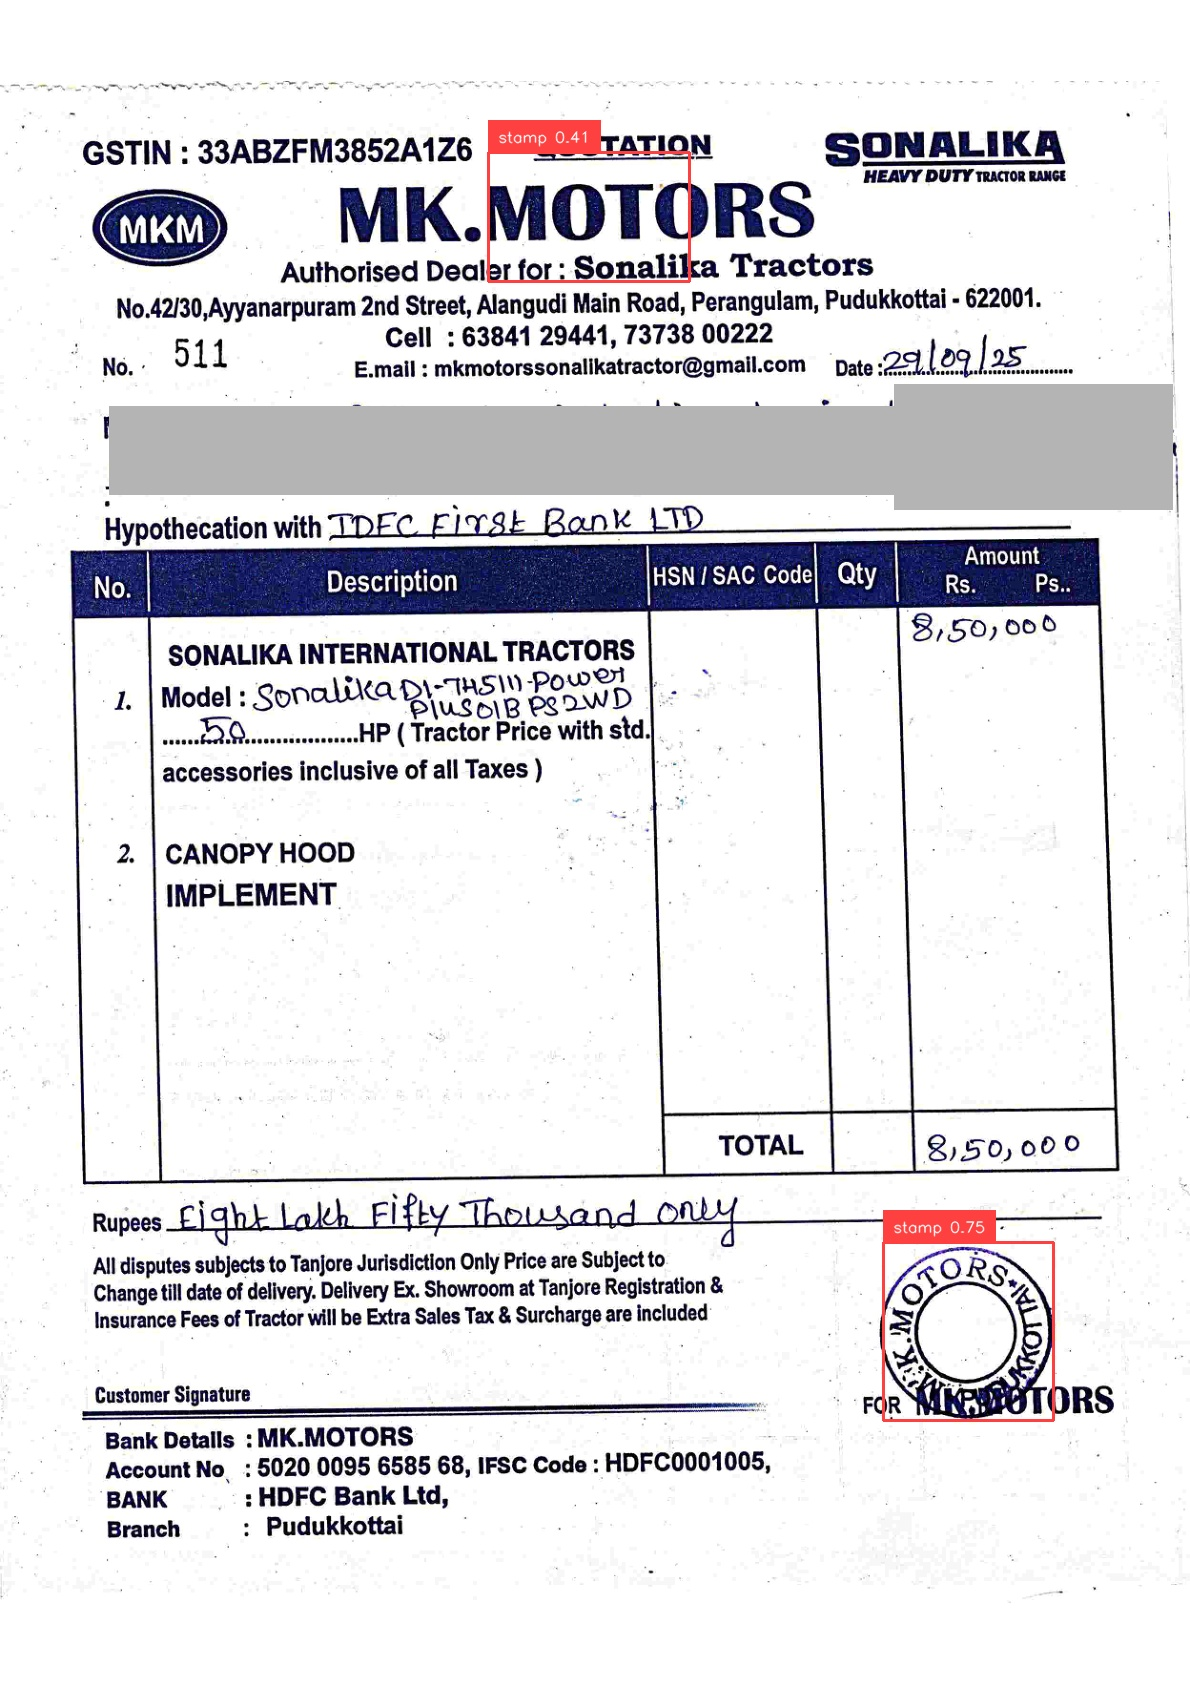

In [22]:
import cv2
from IPython.display import Image, display

cv2.imwrite("result.jpg", result["annotated_image"])
display(Image("result.jpg", width=900))